In [64]:
import torch
import os
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from PIL import Image

from matplotlib import pyplot as plt

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [65]:
vgg19 = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg19 = vgg19.to(device)
for param in vgg19.features.parameters(): # stop training the net
    param.requires_grad = False

Confirm that the network really is loaded onto the GPU.

In [67]:
next(vgg19.parameters()).is_cuda # Should be `True` if you have a GPU

True

### Normalization

vgg19 expects all inputs to be normalized according to the imagenet input means and standard deviations. Un-normalized inputs will still work, but the results are less visually appealing. To help us normalize inputs we will create a custom `Normalization` layer. Everything we pass to our vgg model will go through this layer first. 

In [68]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
normalization_layer = Normalization(normalization_mean, normalization_std).to(device)

Next we make a new network, using the first 13 layers from our pretrained vgg network (for our purposes we won't need the rest) and removing the fully connected layers near the end means we can work with inputs of varying sizes.  

The first layer in our new network will be our custom normalization layer.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [69]:
useful_layers = list(list(vgg19.children())[0])
#useful_layers.insert(0, normalization_layer)

vgg = nn.Sequential(*useful_layers)
print(len(list(vgg.children())))
list(vgg.children())

37


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [70]:
vgg_layers = list(vgg.children())

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

## Prepairing the example texture

The pre-trained networks from torchvision.models need to be passed inputs in a certain format, so we're going to add a transform to apply those transformations to all the image's we're dealing with. We also define a helper function `image_loader` which takes a relative image path, loads the image into a tensor, applies the relevant transformations and returns it.

`show_image` makes it easier to view images we load using `image_loader`. Pytorch doesn't seem to have any good method for visualizing tensors, so we convert the tensor to a numpy array, transpose it and then plot that using matplotlib.

**Note:** `unsqueeze()` is a pytorch function that adds extra dimensions to tensors. We're using it here because vgg19 only takes mini-batches of images, and we're working with a single image. We use `.unsqueeze()` to add the extra dimension to our image tensor and trick vgg into thinking it's dealing with a small minibatch of images. 

In [71]:
transform = transforms.Compose([
        transforms.RandomCrop(300),
        transforms.ToTensor(),
    ])

def image_loader(image_path):
    """load image, returns cuda tensor"""
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def show_image(image_tensor):
    np_image = image_tensor.squeeze().cpu().detach().numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Now we actually load in the image (and also plot it out).

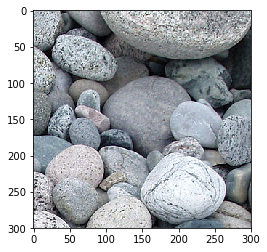

In [72]:
img_path = "data/examples/"
img_name = "stones.jpg" # we use this variable later
full_path = img_path + img_name

example_texture = image_loader(full_path)
show_image(example_texture)

## Extracting Layer activations

The guys in the paper defined the texture profile of the example texture as the **gram matrices** of the feature maps of some of the convolutional or pooling layers in vgg19 after feeding in that example texture. In order to get at these feature maps we're going to use pytorch's hook feature. 

### Hooks

Basically hooks are classes with `.hook_fn`, `.__init__` and `close` methods. `__init__` should take a layer from a module and register the hook's `hook_fn` method on that layer. Whenever the layer is run from then on, `hook_fn` for that hook instance will be called, being passed in the model holding the layer, the layer's input and the layer's output in that order. Let's ignore `close()` for now.

In this case all we want to do is save the output of each layer, so we create a simple `hook_fn` that just saves the layer's output tensor on the hook instance for later use when called.

In [73]:
class SaveFeatures():
    features=None
    def __init__(self, layer): 
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def close(self): 
        self.hook.remove()

The guys from the paper found that we don't need input from every single layer. One from each **scale** of the network (a new scale occurs when the input is down-sampled, i.e. pooling layers) seems to be enough. We register a hook instance on a convolutional or pooling layer from each scale (there are 5 scales in vgg).

In [74]:
layer_feature_maps = []

all_layers = list(vgg.children())

#[1, 3, 6, 8, 11]
#[3, 6, 19, 26, 37]

for index in [2, 5, 18, 25, 36]:
    layer = all_layers[index]
    layer_name = layer.__class__.__name__
    if layer_name == "Conv2d"  or layer_name == 'MaxPool2d' or layer_name == 'AvgPool2d':
        layer_feature_maps.append(SaveFeatures(layer))

print(len(layer_feature_maps)) # should be 5

5


Now we just run our network with all those conv and pooling layers already hooked, and the `.features` attributes of all our hook instances will automatically be populated with the feature maps of all those layers (as per `hook_fn`). 

In [75]:
print(type(layer_feature_maps[2].features) == type(None)) # should be True the first time you run this
vgg(example_texture)
print(layer_feature_maps[2].features[0][0][0]) # should be a tensor with random numbers in

True
tensor([2.2893, 3.0179, 0.0000, 0.0000, 0.0000, 3.6537, 4.1367, 5.0394, 0.0000,
        0.0000, 3.5478, 5.3252, 7.5592, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1573, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3409, 0.0000,
        0.0000], device='cuda:0')


So now we have all the feature maps we need, but for texture synthesis we want to make a gram matrix for each layer's feature maps. Let's make a helper function that takes all the feature maps from a layer and returns a gram matrix. I copy-pasted this myself from somewhere random.

In [76]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d) # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now we have this function, let's use it to create a list of gram matrices, one for each layer we're interested in. This list represents all the summary statistics we will need from the example input. The values in this tensor will probably be tiny, or actually 0.

In [77]:
example_stats = [gram_matrix(layer.features) for layer in layer_feature_maps]
print(len(example_stats)) # should be 5
print(example_stats[0]) # should be a tensor. It will probably have very small values.

5
tensor([[0.0022, 0.0000, 0.0024,  ..., 0.0012, 0.0006, 0.0008],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0024, 0.0000, 0.0101,  ..., 0.0046, 0.0009, 0.0035],
        ...,
        [0.0012, 0.0000, 0.0046,  ..., 0.0028, 0.0005, 0.0016],
        [0.0006, 0.0000, 0.0009,  ..., 0.0005, 0.0008, 0.0006],
        [0.0008, 0.0000, 0.0035,  ..., 0.0016, 0.0006, 0.0064]],
       device='cuda:0')


## Computing Loss

Next we need a way of generating a loss from the example summary statistics (above), and some sample summary statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). The paper recommends calculating the **mean squared error** loss between the two sets of gram matrices.

I had a lot of trouble with this. The losses were always tiny (probably because, as above, the gram matrices I calculated from the feature maps tended to hold super small values), and often resulted in outright 0 gradients. The hacky-as-balls solution I came up with was to literally just scale the loss by some factor before returning. Gross I know.

The paper also recommends using LBFGS to perform gradient updates. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html) for this which you should probably look up. The main takeaway is: if you're using `torch.optim.LBFGS()` as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. Because we can't pass any arguments to the `closure()` function directly, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

We'll also add our loss function to this class for conveniance.

In [78]:
class GradientStepper():
    def __init__(self, optimizer, model, sample_texture, layer_feature_maps, scale):
        self.optimizer = optimizer
        self.sample_texture = sample_texture
        self.model = model
        self.layer_feature_maps = layer_feature_maps
        self.scale = scale

    def loss_fn(self, stats, target_stats):
        loss = 0
        for i in range(len(target_stats)):
            loss += torch.mean((stats[i] - target_stats[i]).pow(2)) # mean squared error

        print("scale: {}".format(self.scale))
        return loss * self.scale
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 

        self.model(self.sample_texture)
        sample_stats = [gram_matrix(layer.features) for layer in self.layer_feature_maps]

        loss = self.loss_fn(sample_stats, example_stats)
        loss.backward()

        print("loss: {}".format(loss))

        return loss


## Create the Sample Texture

Nearly there. Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it against the above loss function until its summary statistics more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them.


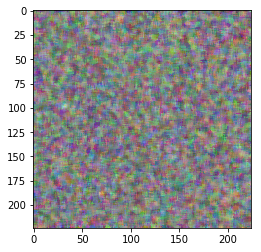

In [79]:
def random_image(blur=6, size=224):
    # create random noise numpy array
    np_sample = np.random.rand(size, size, 3)

    # smooth it out (try commenting out this line and see the difference)
    np_sample = scipy.ndimage.filters.median_filter(np_sample, [blur, blur,1]) 

    # finally convert to a tensor with autograd enabled (since we're 
    # going to be performing gradient updates on this image)
    sample = torch.from_numpy(np_sample).float().permute(2, 0, 1).unsqueeze(0).to(device) 
    sample.requires_grad = True
    
    return sample

show_image(random_image(5))

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture. Once that's done it should look a bit like the example texture (hopefully). To make this clean and reusable, we're going to pack this process into a class called `Synthesizer`, which will take in a bunch of hyperparameters and also save the generated textures as `.jpg`'s for viewing later.

First though, we're going to define some conveniance functions.

In [80]:
def make_optimizer(name, sample_texture, lr):
    if name == "LBFGS":
        return optim.LBFGS([sample_texture], lr=0.1)
    if name == "Adam":
        return optim.Adam([sample_texture], lr=0.1) 
    
    raise ValueError('Name was not a valid optimizer identifier')

### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going. I'm going to give each image an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [81]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["layer_feature_maps", "model", "iterations", "id"]:
            if key == "name":
                id += params[key].replace(".jpg", "") + "-"
            else:
                id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Synthesizer

The only important method is `synthesize`, the rest of it is just there to save the sample textures to the right directories. Basically this method takes a bunch of hyperparameters, generates a (quasi) random image, and performs gradient updates on it for a given number of iterations using the `GradientStepper` class we defined earlier.

In [82]:
class Synthesizer():
    
    sample_directory = "data/samples"
    
    def __init__(self, params):
        self.save_mode = params["save_mode"]
               
    def prepair_save_directory(self, params):
        self.identifier = params["id"]
        
        if self.save_mode == "final":
            self.dir_path = Synthesizer.sample_directory + "/lol"
            self.save_at = params["iterations"]
            
        elif self.save_mode == "throughout":
            self.dir_path = Synthesizer.sample_directory + "/" + self.identifier
            self.save_at = 1
        
        if not os.path.exists(self.dir_path):
            os.makedirs(self.dir_path)
    
    def save_path(self):
        if self.save_mode == "final":
            file_name = self.identifier
        elif self.save_mode == "throughout":
            file_name = self.save_at
        
        return "{}/{}.jpg".format(self.dir_path , file_name)
    
    def synthesize(self, params):
        sample_texture = random_image(params["blur"], params["size"])
        optimizer = make_optimizer(params["optimizer"], sample_texture, params["lr"]) 
        stepper = GradientStepper(optimizer, params["model"], sample_texture, params["layer_feature_maps"], params["scale"])
        
        self.prepair_save_directory(params)

        for i in range (params["iterations"]):
            if sample_texture.grad is not None:
                print(sample_texture.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                save_image(sample_texture, self.save_path())
                self.save_at *= 2
        
        return sample_texture

### Execution

Feel free to fiddle around with hyperparameters here, but I did a fair bit of fiddling myself, and to be honest  the only thing that seemed to make any real difference was the scale, which just needed to remain > 10,000.

In [85]:
params = {
    "name": img_name,
    "size": 300,
    "layers": 5,
    "iterations": 256,
    "blur": 5,
    "scale": 100000,
    "model": vgg,
    "layer_feature_maps": layer_feature_maps,
    "optimizer": "LBFGS",
    "lr": 0.1,
}

meta_params = {
    "save_mode": "final" 
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Synthesizer(meta_params)

for s in [10000]:
    for blur in [5]:
        params["scale"] = s
        params["blur"] = blur
        params["id"] = identifier(params) 

        print(params["id"])

        syn.synthesize(params)

stones-size300-layers5-blur5-scale10000-optimizerLBFGS-lr0.1
scale: 10000
loss: 0.9147657155990601
scale: 10000
loss: 0.9147388339042664
scale: 10000
loss: 0.8199500441551208
scale: 10000
loss: 0.707966148853302
scale: 10000
loss: 0.6143993139266968
scale: 10000
loss: 0.5640670657157898
scale: 10000
loss: 0.5218868851661682
scale: 10000
loss: 0.48626509308815
scale: 10000
loss: 0.4526533782482147
scale: 10000
loss: 0.4208090007305145
scale: 10000
loss: 0.39086583256721497
scale: 10000
loss: 0.36114659905433655
scale: 10000
loss: 0.3337647020816803
scale: 10000
loss: 0.30603864789009094
scale: 10000
loss: 0.28048810362815857
scale: 10000
loss: 0.25531724095344543
scale: 10000
loss: 0.23317192494869232
scale: 10000
loss: 0.21393132209777832
scale: 10000
loss: 0.1975174993276596
scale: 10000
loss: 0.18219614028930664
tensor([-0.0001, -0.0000,  0.0000,  0.0000], device='cuda:0')
scale: 10000
loss: 0.1680622547864914
scale: 10000
loss: 0.15531232953071594
scale: 10000
loss: 0.14298711717128

scale: 10000
loss: 0.002112979767844081
scale: 10000
loss: 0.0020967351738363504
scale: 10000
loss: 0.0020810822024941444
scale: 10000
loss: 0.0020661368034780025
scale: 10000
loss: 0.002050823299214244
scale: 10000
loss: 0.0020355216693133116
scale: 10000
loss: 0.0020207783672958612
scale: 10000
loss: 0.002005573594942689
scale: 10000
loss: 0.001990583259612322
scale: 10000
loss: 0.001974123530089855
scale: 10000
loss: 0.0019594323821365833
tensor([ 6.5586e-08,  7.2938e-08, -1.0111e-07, -2.8287e-07], device='cuda:0')
scale: 10000
loss: 0.0019445606740191579
scale: 10000
loss: 0.0019301421707496047
scale: 10000
loss: 0.0019164796685799956
scale: 10000
loss: 0.0019033042481169105
scale: 10000
loss: 0.0018898624693974853
scale: 10000
loss: 0.0018771546892821789
scale: 10000
loss: 0.0018639813642948866
scale: 10000
loss: 0.0018515005940571427
scale: 10000
loss: 0.0018382146954536438
scale: 10000
loss: 0.0018251236760988832
scale: 10000
loss: 0.0018122780602425337
scale: 10000
loss: 0.0017

scale: 10000
loss: 0.0008567807963117957
scale: 10000
loss: 0.0008542136056348681
scale: 10000
loss: 0.000851802877150476
scale: 10000
loss: 0.0008494877256453037
scale: 10000
loss: 0.0008471589535474777
tensor([-2.0785e-08,  4.1805e-08, -5.1236e-08, -3.3038e-08], device='cuda:0')
scale: 10000
loss: 0.0008447120781056583
scale: 10000
loss: 0.000842345121782273
scale: 10000
loss: 0.0008398533682338893
scale: 10000
loss: 0.0008376234909519553
scale: 10000
loss: 0.0008353088633157313
scale: 10000
loss: 0.0008328562835231423
scale: 10000
loss: 0.0008306907257065177
scale: 10000
loss: 0.000828342221211642
scale: 10000
loss: 0.0008259656606242061
scale: 10000
loss: 0.0008234993438236415
scale: 10000
loss: 0.0008210157393477857
scale: 10000
loss: 0.0008186481427401304
scale: 10000
loss: 0.0008163197198882699
scale: 10000
loss: 0.00081426597898826
scale: 10000
loss: 0.0008121259161271155
scale: 10000
loss: 0.0008099701371975243
scale: 10000
loss: 0.0008079612744040787
scale: 10000
loss: 0.0008

scale: 10000
loss: 0.0005921695264987648
scale: 10000
loss: 0.0005913188797421753
scale: 10000
loss: 0.0005905156722292304
scale: 10000
loss: 0.0005896876100450754
scale: 10000
loss: 0.0005888274172320962
scale: 10000
loss: 0.0005879951640963554
scale: 10000
loss: 0.0005871444009244442
scale: 10000
loss: 0.0005862957332283258
scale: 10000
loss: 0.0005854998016729951
scale: 10000
loss: 0.0005847064312547445
scale: 10000
loss: 0.0005839000805281103
scale: 10000
loss: 0.0005831849412061274
scale: 10000
loss: 0.0005824721301905811
scale: 10000
loss: 0.0005818434292450547
scale: 10000
loss: 0.0005811348673887551
scale: 10000
loss: 0.0005804053507745266
scale: 10000
loss: 0.0005797094199806452
scale: 10000
loss: 0.0005790129071101546
scale: 10000
loss: 0.0005782957305200398
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 10000
loss: 0.0005775804165750742
scale: 10000
loss: 0.0005768790724687278
scale: 10000
loss: 0.0005761713837273419
scale: 10000
loss: 0.000575480225961

scale: 10000
loss: 0.0004906787653453648
scale: 10000
loss: 0.0004903358058072627
scale: 10000
loss: 0.0004899611230939627
scale: 10000
loss: 0.0004896052996627986
scale: 10000
loss: 0.0004892376018688083
scale: 10000
loss: 0.0004888713010586798
scale: 10000
loss: 0.0004885077360086143
scale: 10000
loss: 0.00048814303590916097
scale: 10000
loss: 0.0004877674800809473
scale: 10000
loss: 0.0004874083388131112
scale: 10000
loss: 0.00048703778884373605
scale: 10000
loss: 0.000486673234263435
scale: 10000
loss: 0.00048631569370627403
tensor([-2.8841e-09,  1.6175e-08, -4.7206e-08, -5.0522e-08], device='cuda:0')
scale: 10000
loss: 0.00048593565588817
scale: 10000
loss: 0.00048554677050560713
scale: 10000
loss: 0.0004851762787438929
scale: 10000
loss: 0.0004847850068472326
scale: 10000
loss: 0.0004844128561671823
scale: 10000
loss: 0.0004840517358388752
scale: 10000
loss: 0.0004836909647565335
scale: 10000
loss: 0.0004833439306821674
scale: 10000
loss: 0.0004829977115150541
scale: 10000
loss: 

scale: 10000
loss: 0.00043768397881649435
scale: 10000
loss: 0.00043744550202973187
scale: 10000
loss: 0.00043721351539716125
scale: 10000
loss: 0.0004369827511254698
scale: 10000
loss: 0.0004367359506431967
scale: 10000
loss: 0.00043650847510434687
scale: 10000
loss: 0.0004362715990282595
scale: 10000
loss: 0.0004360457824077457
scale: 10000
loss: 0.00043582372018136084
scale: 10000
loss: 0.000435616442700848
scale: 10000
loss: 0.00043539752368815243
tensor([-3.9239e-08, -3.9582e-08,  6.3977e-09,  9.2781e-09], device='cuda:0')
scale: 10000
loss: 0.00043517505400814116
scale: 10000
loss: 0.00043497441220097244
scale: 10000
loss: 0.000434753717854619
scale: 10000
loss: 0.00043454320984892547
scale: 10000
loss: 0.0004343417822383344
scale: 10000
loss: 0.0004341443127486855
scale: 10000
loss: 0.0004339321458246559
scale: 10000
loss: 0.0004337280697654933
scale: 10000
loss: 0.00043353470391593874
scale: 10000
loss: 0.0004333300166763365
scale: 10000
loss: 0.0004331402888055891
scale: 10000

scale: 10000
loss: 0.0004039592749904841
scale: 10000
loss: 0.00040379661368206143
scale: 10000
loss: 0.0004036422760691494
scale: 10000
loss: 0.00040347781032323837
scale: 10000
loss: 0.0004033167497254908
scale: 10000
loss: 0.0004031668941024691
scale: 10000
loss: 0.0004030162235721946
scale: 10000
loss: 0.0004028691619168967
scale: 10000
loss: 0.00040271447505801916
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 10000
loss: 0.0004025608068332076
scale: 10000
loss: 0.00040240533417090774
scale: 10000
loss: 0.000402259174734354
scale: 10000
loss: 0.00040210713632404804
scale: 10000
loss: 0.00040195012115873396
scale: 10000
loss: 0.000401797064114362
scale: 10000
loss: 0.0004016521852463484
scale: 10000
loss: 0.0004015082377009094
scale: 10000
loss: 0.0004013636789750308
scale: 10000
loss: 0.00040122223435901105
scale: 10000
loss: 0.0004010666161775589
scale: 10000
loss: 0.00040091766277328134
scale: 10000
loss: 0.0004007630923297256
scale: 10000
loss: 0.000400610

scale: 10000
loss: 0.00038122280966490507
scale: 10000
loss: 0.00038112193578854203
scale: 10000
loss: 0.0003810206544585526
scale: 10000
loss: 0.000380924524506554
scale: 10000
loss: 0.0003808324981946498
scale: 10000
loss: 0.00038073555333539844
scale: 10000
loss: 0.0003806333988904953
tensor([-3.5684e-08, -6.1796e-08, -1.8689e-08,  1.8812e-08], device='cuda:0')
scale: 10000
loss: 0.00038053400930948555
scale: 10000
loss: 0.00038043459062464535
scale: 10000
loss: 0.00038033383316360414
scale: 10000
loss: 0.00038023298839107156
scale: 10000
loss: 0.0003801368875429034
scale: 10000
loss: 0.0003800366830546409
scale: 10000
loss: 0.0003799339465331286
scale: 10000
loss: 0.00037984453956596553
scale: 10000
loss: 0.000379750708816573
scale: 10000
loss: 0.0003796542587224394
scale: 10000
loss: 0.0003795574011746794
scale: 10000
loss: 0.0003794620861299336
scale: 10000
loss: 0.00037936517037451267
scale: 10000
loss: 0.0003792762290686369
scale: 10000
loss: 0.0003791804483626038
scale: 10000


scale: 10000
loss: 0.0003644746611826122
scale: 10000
loss: 0.00036439881660044193
scale: 10000
loss: 0.00036432198248803616
tensor([ 9.7099e-09,  3.8383e-08, -2.1940e-08, -9.9653e-09], device='cuda:0')
scale: 10000
loss: 0.00036424430436454713
scale: 10000
loss: 0.0003641669754870236
scale: 10000
loss: 0.0003640855720732361
scale: 10000
loss: 0.00036400475073605776
scale: 10000
loss: 0.000363927916623652
scale: 10000
loss: 0.0003638465132098645
scale: 10000
loss: 0.0003637709596659988
scale: 10000
loss: 0.0003636876353994012
scale: 10000
loss: 0.0003636093169916421
scale: 10000
loss: 0.00036353044561110437
scale: 10000
loss: 0.00036345201078802347
scale: 10000
loss: 0.0003633700544014573
scale: 10000
loss: 0.00036328748683445156
scale: 10000
loss: 0.0003632056759670377
scale: 10000
loss: 0.0003631282306741923
scale: 10000
loss: 0.00036305238609202206
scale: 10000
loss: 0.00036297854967415333
scale: 10000
loss: 0.000362900085747242
scale: 10000
loss: 0.000362818012945354
scale: 10000
l

scale: 10000
loss: 0.0003513397532515228
scale: 10000
loss: 0.00035127674345858395
scale: 10000
loss: 0.0003512091643642634
scale: 10000
loss: 0.0003511490940582007
scale: 10000
loss: 0.0003510865499265492
scale: 10000
loss: 0.0003510267415549606
scale: 10000
loss: 0.0003509643138386309
scale: 10000
loss: 0.0003509027592372149
scale: 10000
loss: 0.00035084469709545374
scale: 10000
loss: 0.0003507779911160469
scale: 10000
loss: 0.0003507158544380218
scale: 10000
loss: 0.00035065854899585247
scale: 10000
loss: 0.00035060179652646184
scale: 10000
loss: 0.00035053875762969255
scale: 10000
loss: 0.0003504818014334887
scale: 10000
loss: 0.00035042769741266966
scale: 10000
loss: 0.0003503680054564029
scale: 10000
loss: 0.00035030857543461025
scale: 10000
loss: 0.0003502471081446856
tensor([-4.7073e-09,  7.1028e-08,  3.1766e-08,  1.4412e-08], device='cuda:0')
scale: 10000
loss: 0.00035019067581743
scale: 10000
loss: 0.0003501313040032983
scale: 10000
loss: 0.0003500787715893239
scale: 10000
lo

scale: 10000
loss: 0.00034107259125448763
scale: 10000
loss: 0.0003410246572457254
scale: 10000
loss: 0.0003409714554436505
scale: 10000
loss: 0.000340918981237337
scale: 10000
loss: 0.00034086720552295446
scale: 10000
loss: 0.00034081697231158614
scale: 10000
loss: 0.00034076598240062594
scale: 10000
loss: 0.0003407199401408434
scale: 10000
loss: 0.0003406704345252365
scale: 10000
loss: 0.0003406165633350611
scale: 10000
loss: 0.0003405697352718562
scale: 10000
loss: 0.00034052113187499344
scale: 10000
loss: 0.000340472673997283
scale: 10000
loss: 0.00034041941398754716
scale: 10000
loss: 0.00034037025761790574
scale: 10000
loss: 0.00034032214898616076
scale: 10000
loss: 0.00034027115907520056
tensor([-4.4036e-08, -4.4290e-08, -2.2296e-08,  2.8518e-08], device='cuda:0')
scale: 10000
loss: 0.00034021929604932666
scale: 10000
loss: 0.0003401699068490416
scale: 10000
loss: 0.0003401203139219433
scale: 10000
loss: 0.0003400699933990836
scale: 10000
loss: 0.00034001865424215794
scale: 1000

scale: 10000
loss: 0.00033273245207965374
scale: 10000
loss: 0.00033269173582084477
scale: 10000
loss: 0.0003326515725348145
scale: 10000
loss: 0.0003326065489090979
scale: 10000
loss: 0.0003325662692077458
scale: 10000
loss: 0.00033252633875235915
scale: 10000
loss: 0.000332488096319139
scale: 10000
loss: 0.00033244455698877573
scale: 10000
loss: 0.0003324027929920703
scale: 10000
loss: 0.0003323618439026177
scale: 10000
loss: 0.0003323216806165874
scale: 10000
loss: 0.0003322814591228962
scale: 10000
loss: 0.00033224260550923645
tensor([ 1.4094e-08,  4.8369e-08, -5.1576e-09, -3.1407e-08], device='cuda:0')
scale: 10000
loss: 0.000332199182594195
scale: 10000
loss: 0.00033215954317711294
scale: 10000
loss: 0.0003321171388961375
scale: 10000
loss: 0.0003320772957522422
scale: 10000
loss: 0.000332033378072083
scale: 10000
loss: 0.0003319932729937136
scale: 10000
loss: 0.000331953342538327
scale: 10000
loss: 0.0003319166135042906
scale: 10000
loss: 0.0003318770322948694
scale: 10000
loss:

scale: 10000
loss: 0.00032571455813013017
scale: 10000
loss: 0.0003256789059378207
scale: 10000
loss: 0.0003256448544561863
scale: 10000
loss: 0.0003256102208979428
scale: 10000
loss: 0.00032557558733969927
scale: 10000
loss: 0.00032553859637118876
scale: 10000
loss: 0.00032550428295508027
scale: 10000
loss: 0.0003254699695389718
scale: 10000
loss: 0.0003254380135331303
tensor([-1.3577e-08, -1.1646e-08,  4.8366e-08,  2.3242e-08], device='cuda:0')
scale: 10000
loss: 0.0003254046314395964
scale: 10000
loss: 0.00032537119113840163
scale: 10000
loss: 0.0003253363538533449
scale: 10000
loss: 0.0003253012546338141
scale: 10000
loss: 0.000325267028529197
scale: 10000
loss: 0.00032523125992156565
scale: 10000
loss: 0.00032519709202460945
scale: 10000
loss: 0.0003251622256357223
scale: 10000
loss: 0.0003251269808970392
scale: 10000
loss: 0.0003250913869123906
scale: 10000
loss: 0.00032505972194485366
scale: 10000
loss: 0.00032502738758921623
scale: 10000
loss: 0.0003249919100198895
scale: 10000

scale: 10000
loss: 0.0003197912301402539
scale: 10000
loss: 0.0003197623009327799
scale: 10000
loss: 0.00031973342993296683
scale: 10000
loss: 0.00031970578129403293
scale: 10000
loss: 0.0003196780744474381
scale: 10000
loss: 0.0003196480101905763
scale: 10000
loss: 0.00031961852801032364
tensor([ 3.1391e-09, -1.1527e-08,  1.1322e-08, -1.5639e-08], device='cuda:0')
scale: 10000
loss: 0.00031959082116372883
scale: 10000
loss: 0.00031956163002178073
scale: 10000
loss: 0.00031953328289091587
scale: 10000
loss: 0.0003195044118911028
scale: 10000
loss: 0.0003194744058419019
scale: 10000
loss: 0.00031944530201144516
scale: 10000
loss: 0.000319415470585227
scale: 10000
loss: 0.0003193865704815835
scale: 10000
loss: 0.00031935545848682523
scale: 10000
loss: 0.0003193275770172477
scale: 10000
loss: 0.00031929800752550364
scale: 10000
loss: 0.0003192686417605728
scale: 10000
loss: 0.00031924244831316173
scale: 10000
loss: 0.00031921829213388264
scale: 10000
loss: 0.00031919029424898326
scale: 10

scale: 10000
loss: 0.00031486732768826187
scale: 10000
loss: 0.00031484311330132186
scale: 10000
loss: 0.0003148192772641778
scale: 10000
loss: 0.00031479392782785
scale: 10000
loss: 0.0003147685492876917
tensor([2.4450e-08, 5.3067e-08, 2.8528e-08, 1.7685e-08], device='cuda:0')
scale: 10000
loss: 0.0003147433162666857
scale: 10000
loss: 0.0003147171519231051
scale: 10000
loss: 0.00031469299574382603
scale: 10000
loss: 0.00031466729706153274
scale: 10000
loss: 0.0003146416856907308
scale: 10000
loss: 0.00031461886828765273
scale: 10000
loss: 0.00031459276215173304
scale: 10000
loss: 0.0003145676455460489
scale: 10000
loss: 0.0003145411319565028
scale: 10000
loss: 0.0003145145601592958
scale: 10000
loss: 0.00031449072412215173
scale: 10000
loss: 0.00031446703360415995
scale: 10000
loss: 0.00031444180058315396
scale: 10000
loss: 0.00031441685860045254
scale: 10000
loss: 0.00031439290614798665
scale: 10000
loss: 0.00031436694553121924
scale: 10000
loss: 0.00031434278935194016
scale: 10000


scale: 10000
loss: 0.0003105876676272601
scale: 10000
loss: 0.0003105643263552338
scale: 10000
loss: 0.000310542673105374
tensor([5.4750e-09, 2.4997e-08, 8.3114e-09, 1.3233e-08], device='cuda:0')
scale: 10000
loss: 0.00031052305712364614
scale: 10000
loss: 0.0003105018113274127
scale: 10000
loss: 0.0003104796342086047
scale: 10000
loss: 0.00031045969808474183
scale: 10000
loss: 0.00031043760827742517
scale: 10000
loss: 0.00031041508191265166
scale: 10000
loss: 0.00031039482564665377
scale: 10000
loss: 0.00031037331791594625
scale: 10000
loss: 0.000310352275846526
scale: 10000
loss: 0.000310328759951517
scale: 10000
loss: 0.0003103071649093181
scale: 10000
loss: 0.0003102874616160989
scale: 10000
loss: 0.0003102662449236959
scale: 10000
loss: 0.0003102449991274625
scale: 10000
loss: 0.00031022465554997325
scale: 10000
loss: 0.00031020352616906166
scale: 10000
loss: 0.0003101833863183856
scale: 10000
loss: 0.0003101620532106608
scale: 10000
loss: 0.00031013996340334415
scale: 10000
loss:

scale: 10000
loss: 0.00030680393683724105
tensor([ 1.0937e-08,  1.2586e-08,  5.4900e-09, -1.4172e-09], device='cuda:0')
scale: 10000
loss: 0.00030678644543513656
scale: 10000
loss: 0.0003067673824261874
scale: 10000
loss: 0.0003067494835704565
scale: 10000
loss: 0.0003067320503760129
scale: 10000
loss: 0.000306713831378147
scale: 10000
loss: 0.00030669517582282424
scale: 10000
loss: 0.0003066777717322111
scale: 10000
loss: 0.0003066592325922102
scale: 10000
loss: 0.00030664034420624375
scale: 10000
loss: 0.00030662352219223976
scale: 10000
loss: 0.0003066053322982043
scale: 10000
loss: 0.000306588364765048
scale: 10000
loss: 0.00030657098977826536
scale: 10000
loss: 0.00030655390582978725
scale: 10000
loss: 0.00030653493013232946
scale: 10000
loss: 0.00030651676934212446
scale: 10000
loss: 0.00030649936525151134
scale: 10000
loss: 0.0003064823104068637
scale: 10000
loss: 0.0003064638585783541
scale: 10000
loss: 0.0003064458433073014
tensor([ 1.5598e-08,  3.5300e-08,  9.6186e-09, -1.829

scale: 10000
loss: 0.0003034903493244201
scale: 10000
loss: 0.0003034733235836029
scale: 10000
loss: 0.0003034568508155644
scale: 10000
loss: 0.0003034383989870548
scale: 10000
loss: 0.0003034210531041026
scale: 10000
loss: 0.0003034025721717626
scale: 10000
loss: 0.00030338592478074133
scale: 10000
loss: 0.0003033680550288409
scale: 10000
loss: 0.00030335059273056686
scale: 10000
loss: 0.0003033328684978187
scale: 10000
loss: 0.0003033141838386655
scale: 10000
loss: 0.0003032952081412077
scale: 10000
loss: 0.0003032763779629022
scale: 10000
loss: 0.0003032582753803581
scale: 10000
loss: 0.00030323982355184853
scale: 10000
loss: 0.00030322204111143947
scale: 10000
loss: 0.00030320422956719995
scale: 10000
loss: 0.0003031858941540122
scale: 10000
loss: 0.00030316796619445086
tensor([8.1039e-09, 2.7458e-08, 7.3428e-09, 1.3782e-08], device='cuda:0')
scale: 10000
loss: 0.00030315102776512504
scale: 10000
loss: 0.00030313318711705506
scale: 10000
loss: 0.0003031166852451861
scale: 10000
los

scale: 10000
loss: 0.0003004134923685342
scale: 10000
loss: 0.00030039704870432615
scale: 10000
loss: 0.0003003817982971668
scale: 10000
loss: 0.00030036605312488973
scale: 10000
loss: 0.00030034894007258117
scale: 10000
loss: 0.0003003325255122036
scale: 10000
loss: 0.0003003170422744006
scale: 10000
loss: 0.000300301646348089
scale: 10000
loss: 0.0003002857556566596
scale: 10000
loss: 0.0003002678568009287
scale: 10000
loss: 0.0003002496960107237
scale: 10000
loss: 0.0003002341545652598
scale: 10000
loss: 0.00030021602287888527
scale: 10000
loss: 0.00030019847326911986
scale: 10000
loss: 0.00030018153483979404
tensor([-7.5760e-09, -7.7843e-09,  3.0756e-08,  3.6484e-08], device='cuda:0')
scale: 10000
loss: 0.00030016349046491086
scale: 10000
loss: 0.0003001484146807343
scale: 10000
loss: 0.00030013173818588257
scale: 10000
loss: 0.0003001158474944532
scale: 10000
loss: 0.00030010080081410706
scale: 10000
loss: 0.00030008581234142184
scale: 10000
loss: 0.0003000716969836503
scale: 1000

scale: 10000
loss: 0.00029773838468827307
scale: 10000
loss: 0.0002977255790028721
scale: 10000
loss: 0.00029771303525194526
scale: 10000
loss: 0.000297698745271191
scale: 10000
loss: 0.0002976848336402327
scale: 10000
loss: 0.00029767100932076573
scale: 10000
loss: 0.0002976578543893993
scale: 10000
loss: 0.00029764435021206737
scale: 10000
loss: 0.0002976316900458187
scale: 10000
loss: 0.00029761760379187763
scale: 10000
loss: 0.0002976041578222066
scale: 10000
loss: 0.0002975895185954869
scale: 10000
loss: 0.0002975759853143245
tensor([ 1.6958e-08,  6.0127e-08,  3.3674e-08, -6.3101e-09], device='cuda:0')
scale: 10000
loss: 0.0002975631505250931
scale: 10000
loss: 0.00029755072318948805
scale: 10000
loss: 0.00029753759736195207
scale: 10000
loss: 0.00029752415139228106
scale: 10000
loss: 0.0002975112001877278
scale: 10000
loss: 0.0002974974340759218
scale: 10000
loss: 0.0002974829694721848
scale: 10000
loss: 0.00029746914515271783
scale: 10000
loss: 0.0002974546223413199
scale: 10000

scale: 10000
loss: 0.000295286881737411
scale: 10000
loss: 0.0002952735230792314
scale: 10000
loss: 0.00029526057187467813
scale: 10000
loss: 0.00029524779529310763
scale: 10000
loss: 0.00029523615376092494
scale: 10000
loss: 0.00029522442491725087
scale: 10000
loss: 0.00029521106625907123
scale: 10000
loss: 0.0002951979695353657
scale: 10000
loss: 0.0002951851347461343
scale: 10000
loss: 0.0002951717469841242
scale: 10000
loss: 0.00029515978530980647
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 10000
loss: 0.0002951468632090837
scale: 10000
loss: 0.000295134203042835
scale: 10000
loss: 0.00029512119363062084
scale: 10000
loss: 0.00029510914464481175
scale: 10000
loss: 0.00029509709565900266
scale: 10000
loss: 0.0002950845519080758
scale: 10000
loss: 0.00029507215367630124
scale: 10000
loss: 0.00029505870770663023
scale: 10000
loss: 0.00029504491249099374
scale: 10000
loss: 0.00029503184487111866
scale: 10000
loss: 0.0002950199996121228
scale: 10000
loss: 0.0002

scale: 10000
loss: 0.0002930163755081594
scale: 10000
loss: 0.00029300618916749954
scale: 10000
loss: 0.00029299414018169045
scale: 10000
loss: 0.00029298258596099913
scale: 10000
loss: 0.00029297074070200324
scale: 10000
loss: 0.0002929586626123637
scale: 10000
loss: 0.0002929464098997414
tensor([-1.1963e-08, -1.7191e-08,  3.7465e-09,  8.2435e-09], device='cuda:0')
scale: 10000
loss: 0.0002929344482254237
scale: 10000
loss: 0.000292922806693241
scale: 10000
loss: 0.0002929118927568197
scale: 10000
loss: 0.00029290030943229795
scale: 10000
loss: 0.0002928877656813711
scale: 10000
loss: 0.00029287434881553054
scale: 10000
loss: 0.0002928610483650118
scale: 10000
loss: 0.00029284856282174587
scale: 10000
loss: 0.00029283700860105455
scale: 10000
loss: 0.0002928237372543663
scale: 10000
loss: 0.000292810465907678
scale: 10000
loss: 0.00029279894079081714
scale: 10000
loss: 0.00029278729925863445
scale: 10000
loss: 0.0002927755704149604
scale: 10000
loss: 0.0002927651221398264
scale: 10000

scale: 10000
loss: 0.00029097290826030076
scale: 10000
loss: 0.00029096155776642263
scale: 10000
loss: 0.0002909497416112572
scale: 10000
loss: 0.0002909386239480227
scale: 10000
loss: 0.0002909277391154319
tensor([-5.9346e-09, -1.0960e-08,  1.8496e-08,  1.0325e-08], device='cuda:0')
scale: 10000
loss: 0.00029091574833728373
scale: 10000
loss: 0.000290904805297032
scale: 10000
loss: 0.00029089266899973154
scale: 10000
loss: 0.0002908814640250057
scale: 10000
loss: 0.00029087087023071945
scale: 10000
loss: 0.00029086045105941594
scale: 10000
loss: 0.00029085000278428197
scale: 10000
loss: 0.0002908378082793206
scale: 10000
loss: 0.0002908276510424912
scale: 10000
loss: 0.00029081644606776536
scale: 10000
loss: 0.00029080582316964865
scale: 10000
loss: 0.00029079511296004057
scale: 10000
loss: 0.00029078530496917665
scale: 10000
loss: 0.0002907754678744823
scale: 10000
loss: 0.0002907649031840265
scale: 10000
loss: 0.00029075448401272297
scale: 10000
loss: 0.0002907445596065372
scale: 10

scale: 10000
loss: 0.0002891041513066739
tensor([-1.1056e-08, -1.2594e-08,  3.6866e-09,  1.1342e-08], device='cuda:0')
scale: 10000
loss: 0.00028909495449624956
scale: 10000
loss: 0.00028908520471304655
scale: 10000
loss: 0.0002890746109187603
scale: 10000
loss: 0.00028906462830491364
scale: 10000
loss: 0.00028905493672937155
scale: 10000
loss: 0.00028904509963467717
scale: 10000
loss: 0.00028903488419018686
scale: 10000
loss: 0.0002890261239372194
scale: 10000
loss: 0.00028901713085360825
scale: 10000
loss: 0.00028900758479721844
scale: 10000
loss: 0.0002889981842599809
scale: 10000
loss: 0.00028898840537294745
scale: 10000
loss: 0.00028897891752421856
scale: 10000
loss: 0.0002889693423639983
scale: 10000
loss: 0.00028896110597997904
scale: 10000
loss: 0.00028895208379253745
scale: 10000
loss: 0.0002889429742936045
scale: 10000
loss: 0.0002889340394176543
scale: 10000
loss: 0.00028892510454170406
scale: 10000
loss: 0.00028891683905385435
tensor([-1.4891e-08, -1.1714e-08,  2.3265e-08, 

scale: 10000
loss: 0.0002874109777621925
scale: 10000
loss: 0.0002874018100555986
scale: 10000
loss: 0.0002873931371141225
scale: 10000
loss: 0.00028738417313434184
scale: 10000
loss: 0.000287373986793682
scale: 10000
loss: 0.00028736557578668
scale: 10000
loss: 0.000287357164779678
scale: 10000
loss: 0.0002873483463190496
scale: 10000
loss: 0.0002873397897928953
scale: 10000
loss: 0.00028733129147440195
scale: 10000
loss: 0.0002873208140954375
scale: 10000
loss: 0.0002873120829463005
scale: 10000
loss: 0.00028730437043122947
scale: 10000
loss: 0.00028729639598168433
scale: 10000
loss: 0.0002872874611057341
scale: 10000
loss: 0.00028727937024086714
scale: 10000
loss: 0.0002872711920645088
scale: 10000
loss: 0.00028726249001920223
scale: 10000
loss: 0.00028725372976623476
tensor([-1.6128e-08, -2.1440e-08, -4.9423e-09,  2.3417e-09], device='cuda:0')
scale: 10000
loss: 0.0002872448822017759
scale: 10000
loss: 0.00028723583091050386
scale: 10000
loss: 0.00028722724528051913
scale: 10000
lo

scale: 10000
loss: 0.00028579231002368033
scale: 10000
loss: 0.0002857838699128479
scale: 10000
loss: 0.00028577647753991187
scale: 10000
loss: 0.0002857681829482317
scale: 10000
loss: 0.0002857593062799424
scale: 10000
loss: 0.0002857502258848399
scale: 10000
loss: 0.0002857421641238034
scale: 10000
loss: 0.00028573369490914047
scale: 10000
loss: 0.00028572537121362984
scale: 10000
loss: 0.0002857177169062197
scale: 10000
loss: 0.00028570840368047357
scale: 10000
loss: 0.00028570028371177614
scale: 10000
loss: 0.0002856913779396564
scale: 10000
loss: 0.0002856824139598757
scale: 10000
loss: 0.00028567438130266964
tensor([-1.0953e-08, -8.6808e-09,  1.3069e-08,  1.6723e-08], device='cuda:0')
scale: 10000
loss: 0.00028566629043780267
scale: 10000
loss: 0.0002856570645235479
scale: 10000
loss: 0.00028564786771312356
scale: 10000
loss: 0.0002856386126950383
scale: 10000
loss: 0.00028562959050759673
scale: 10000
loss: 0.00028562001534737647
scale: 10000
loss: 0.00028560985811054707
scale: 1

scale: 10000
loss: 0.0002842302492354065
scale: 10000
loss: 0.0002842222456820309
scale: 10000
loss: 0.0002842129033524543
scale: 10000
loss: 0.00028420440503396094
scale: 10000
loss: 0.0002841954701580107
scale: 10000
loss: 0.0002841866225935519
scale: 10000
loss: 0.00028417844441719353
scale: 10000
loss: 0.00028416974237188697
scale: 10000
loss: 0.0002841623208951205
scale: 10000
loss: 0.0002841530367732048
scale: 10000
loss: 0.0002841451787389815
scale: 10000
loss: 0.000284136098343879
scale: 10000
loss: 0.00028412695974111557
tensor([-1.4769e-08, -4.2474e-08, -2.9533e-08,  5.9428e-11], device='cuda:0')
scale: 10000
loss: 0.0002841179957613349
scale: 10000
loss: 0.0002841090608853847
scale: 10000
loss: 0.00028410006780177355
scale: 10000
loss: 0.00028409078367985785
scale: 10000
loss: 0.0002840823435690254
scale: 10000
loss: 0.00028407369973137975
scale: 10000
loss: 0.0002840642991941422
scale: 10000
loss: 0.00028405620832927525
scale: 10000
loss: 0.0002840470115188509
scale: 10000


scale: 10000
loss: 0.0002827649295795709
scale: 10000
loss: 0.0002827575081028044
scale: 10000
loss: 0.000282749708276242
scale: 10000
loss: 0.0002827416465152055
scale: 10000
loss: 0.0002827342541422695
scale: 10000
loss: 0.0002827259595505893
scale: 10000
loss: 0.0002827184507623315
scale: 10000
loss: 0.00028271146584302187
scale: 10000
loss: 0.0002827031130436808
scale: 10000
loss: 0.0002826955169439316
scale: 10000
loss: 0.0002826882409863174
tensor([-1.1330e-08, -1.4162e-08, -6.7649e-10,  6.8857e-09], device='cuda:0')
scale: 10000
loss: 0.0002826804993674159
scale: 10000
loss: 0.0002826731652021408
scale: 10000
loss: 0.0002826664422173053
scale: 10000
loss: 0.0002826592535711825
scale: 10000
loss: 0.00028265209402889013
scale: 10000
loss: 0.000282645138213411
scale: 10000
loss: 0.0002826377749443054
scale: 10000
loss: 0.00028263102285563946
scale: 10000
loss: 0.00028262424166314304
scale: 10000
loss: 0.00028261676197871566
scale: 10000
loss: 0.0002826089330483228
scale: 10000
loss